In [11]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
import h3
import pandas as pd
import geopandas as gpd
import numpy as np
import folium
from src.settings import *
from shapely.geometry import Polygon
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from src.tools.osmnx_utils import get_place_dir_name
from src.tools.h3_utils import get_resolution_buffered_suffix, get_edges_with_features_filename
from pathlib import Path
import plotly.express as px
from src.tools.clustering import cluster_hdbscan
from src.models.tfidf import tfidf
from src.tools.dim_reduction import reduce_umap
import matplotlib.pyplot as plt
import contextily as ctx
from keplergl import KeplerGl
from src.tools.aggregation import aggregate_hex
import torch
from torch import nn
import torch.nn.functional as F
import pytorch_lightning as pl
from torch.utils.data.dataloader import DataLoader
from torch.utils.data.dataset import Dataset
from pytorch_lightning.loggers import WandbLogger
import wandb
from src.models.autoencoder import LitAutoEncoder
import random
from src.tools.feature_extraction import apply_feature_selection
import json5 as json

tqdm.pandas()

In [13]:
torch.manual_seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

# def seed_worker(worker_id):
#     worker_seed = torch.initial_seed() % 2**32
#     np.random.seed(worker_seed)
#     random.seed(worker_seed)

In [14]:
cities = pd.read_csv(RAW_DATA_DIR / "cities.csv")
cities = cities[(cities.country == "Poland") & (cities.kacper)]
cities

,city,country,kacper,szymon,piotr,kamil,regions
63,Białystok,Poland,True,False,False,False,NaN
64,Bydgoszcz,Poland,True,False,True,False,NaN
65,Częstochowa,Poland,True,False,False,False,NaN
69,Kraków,Poland,True,True,True,False,NaN
70,Lublin,Poland,True,False,True,False,NaN
71,Łódź,Poland,True,True,False,False,NaN
72,Poznań,Poland,True,True,True,True,NaN
75,Szczecin,Poland,True,True,True,False,NaN
77,Trójmiasto,Poland,True,False,True,False,"['Gdańsk','Gdynia','Sopot']"
78,Warszawa,Poland,True,True,True,True,NaN


In [15]:
resolution = 9
buffered = True
network_type = "drive"
intersection_based = False

pbar = tqdm(cities.itertuples(), total=cities.shape[0])
hexagons = []
edges = []
for row in pbar:
    place_name = f"{row.city},{row.country}"
    place_dir_name = get_place_dir_name(place_name)
    place_dir_path = GENERATED_DATA_DIR / place_dir_name
    gpkg_path = place_dir_path / f"graph_{network_type}.gpkg"
    pbar.set_description(place_name)

    try:
        hexagons_city = gpd.read_file(gpkg_path, layer=f"hex_{get_resolution_buffered_suffix(resolution, buffered)}")
        hexagons_city["city"] = row.city
        hexagons_city["country"] = row.country
        hexagons.append(hexagons_city)

        edges_city = gpd.read_feather(place_dir_path / get_edges_with_features_filename(network_type, resolution, buffered, intersection_based))
        edges_city["city"] = row.city
        edges_city["country"] = row.country
        edges.append(edges_city)
    except Exception as e:
        print("\nFailed", place_name, e)
    

hexagons = pd.concat(hexagons, ignore_index=True).set_index("h3_id")
edges = gpd.GeoDataFrame(pd.concat(edges, ignore_index=True))
# hex_agg_tfidf = tfidf(hex_agg)

del hexagons_city
del edges_city

Zielona Góra,Poland: 100%|██████████| 12/12 [00:05<00:00,  2.22it/s]


In [16]:
with open(RAW_DATA_DIR / "featureset_selection_1.jsonc", "r") as f:
    featureset_selection_config = json.load(f)
edges_feature_selection = apply_feature_selection(edges, featureset_selection_config)
edges_feature_selection["h3_id"] = edges["h3_id"]
edges_feature_selection["city"] = edges["city"]
edges_feature_selection["country"] = edges["country"]
print(len(edges_feature_selection.columns))
print(edges_feature_selection.columns)

83
Index(['oneway_True', 'lanes_1', 'lanes_2', 'lanes_3', 'lanes_4', 'lanes_5',
       'lanes_6', 'lanes_7', 'lanes_8', 'lanes_9', 'lanes_10',
       'highway_living_street', 'highway_motorway', 'highway_motorway_link',
       'highway_primary', 'highway_primary_link', 'highway_residential',
       'highway_secondary', 'highway_secondary_link', 'highway_tertiary',
       'highway_tertiary_link', 'highway_trunk', 'highway_trunk_link',
       'highway_unclassified', 'maxspeed_5', 'maxspeed_7', 'maxspeed_10',
       'maxspeed_15', 'maxspeed_20', 'maxspeed_30', 'maxspeed_40',
       'maxspeed_50', 'maxspeed_60', 'maxspeed_70', 'maxspeed_80',
       'maxspeed_90', 'maxspeed_100', 'maxspeed_110', 'maxspeed_120',
       'maxspeed_130', 'maxspeed_140', 'bridge_yes', 'bridge_cantilever',
       'bridge_covered', 'bridge_low_water_crossing', 'bridge_movable',
       'bridge_viaduct', 'access_no', 'access_permissive', 'access_permit',
       'access_destination', 'access_delivery', 'access_custom

In [17]:
hex_agg = edges_feature_selection.groupby(["country", "city", "h3_id"]).sum()
hex_agg

oneway_True  lanes_1  lanes_2  lanes_3  \
country city      h3_id                                                     
Poland  Białystok 891f5104d23ffff            1        0        1        1   
                  891f5104d2bffff            4        2        2        1   
                  891f5104d37ffff            2        0        2        2   
                  891f5104da7ffff            6        0        5        1   
                  891f5104db7ffff            5        0        3        1   
...                                        ...      ...      ...      ...   
        Łódź      891f5249ba7ffff            0        0        0        0   
                  891f5249babffff            0        0        0        0   
                  891f5249bafffff            0        0        0        0   
                  891f5249bb3ffff            0        0        0        0   
                  891f5249bb7ffff            0        0        0        0   

                                   lanes_4  lanes_5  lanes_6  lanes_7  \
country city      h3_id                                                 
Poland  Białystok 891f5104d23ffff        0        0        0        0   
                  891f5104d2bffff        0        0        0        0   
                  891f5104d37ffff        0        0        0        0   
                  891f5104da7ffff        0        0        0        0   
                  891f5104db7ffff        0        0        0        0   
...                                    ...      ...      ...      ...   
        Łódź      891f5249ba7ffff        0        0        0        0   
                  891f5249babffff        0        0        0        0   
                  891f5249bafffff        0        0        0        0   
                  891f5249bb3ffff        0        0        0        0   
                  891f5249bb7ffff        0        0        0        0   

                                   lanes_8  lanes_9  ...  width_13.0  \
country city      h3_id                              ...               
Poland  Białystok 891f5104d23ffff        0        0  ...           0   
                  891f5104d2bffff        0        0  ...           0   
                  891f5104d37ffff        0        0  ...           0   
                  891f5104da7ffff        0        0  ...           0   
                  891f5104db7ffff        0        0  ...           0   
...                                    ...      ...  ...         ...   
        Łódź      891f5249ba7ffff        0        0  ...           0   
                  891f5249babffff        0        0  ...           0   
                  891f5249bafffff        0        0  ...           0   
                  891f5249bb3ffff        0        0  ...           0   
                  891f5249bb7ffff        0        0  ...           0   

                                   width_14.0  width_15.0  width_16.0  \
country city      h3_id                                                 
Poland  Białystok 891f5104d23ffff           0           0           0   
                  891f5104d2bffff           0           0           0   
                  891f5104d37ffff           0           0           0   
                  891f5104da7ffff           0           0           0   
                  891f5104db7ffff           0           0           0   
...                                       ...         ...         ...   
        Łódź      891f5249ba7ffff           0           0           0   
                  891f5249babffff           0           0           0   
                  891f5249bafffff           0           0           0   
                  891f5249bb3ffff           0           0           0   
                  891f5249bb7ffff           0           0           0   

                                   width_17.0  width_18.0  width_19.0  \
country city      h3_id                                                 
Poland  Białystok 891f5104d23ffff           0     

### TODO add preprocessing (global, local normalization)

In [18]:
test_city = "Łódź"

hex_agg_train = hex_agg.drop(index=[test_city], level=1)
hex_agg_test = hex_agg.loc["Poland", test_city]

In [19]:
X_train = torch.Tensor(hex_agg_train.values)
X_test = torch.Tensor(hex_agg_test.values)

batch_size = 200
num_workers = 5
shuffle = True

X_train_dl = DataLoader(X_train, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)
X_test_dl = DataLoader(X_test, batch_size=batch_size, shuffle=False, num_workers=num_workers)

n_features = X_train.shape[1]

In [20]:
wandb_logger = WandbLogger()
run = wandb.init(project="osm-autoencoder", dir=CHECKPOINTS_DIR, reinit=True)

hidden_dim = 64
code_dim = 30
epochs = 5
lr = 1e-3

model = LitAutoEncoder(in_dim=n_features, hidden_dim=hidden_dim, code_dim=code_dim, lr=lr)
trainer = pl.Trainer(gpus=1, max_epochs=epochs, logger=wandb_logger, default_root_dir=CHECKPOINTS_DIR)
trainer.fit(model, train_dataloaders=X_train_dl, val_dataloaders=X_test_dl)

run.finish()

epoch,▁▁▁▃▃▃▃▅▅▅▅▆▆▆▆████
train_loss_epoch,█▃▂▁▁
train_loss_step,█▅▃▂▂▂▁▁▁
trainer/global_step,▂▁▁▁▁▁▁▂▃▁▁▁▁▁▁▄▅▁▁▁▁▁▁▅▆▂▂▂▂▂▂▇▇▂▂▂▂▂▂█
val_loss_epoch,█▃▂▁▁
val_loss_step,▆▅▄▇▇▃█▅▃▂▂▃▄▂▄▂▂▂▂▂▃▁▂▂▁▁▁▂▂▁▂▁▁▁▁▁▂▁▂▁
epoch,4
train_loss_epoch,0.07504
train_loss_step,0.07227
trainer/global_step,494
val_loss_epoch,0.0466


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 7.1 K 
1 | decoder | Sequential | 7.2 K 
---------------------------------------
14.3 K    Trainable params
0         Non-trainable params
14.3 K    Total params
0.057     Total estimated model params size (MB)


Epoch 4: 100%|██████████| 111/111 [00:03<00:00, 30.22it/s, loss=0.0659, v_num=4uur, train_loss_step=0.0665, val_loss_step=0.0205, val_loss_epoch=0.0466, train_loss_epoch=0.0997]


In [25]:
model.eval()
y = model(torch.cat([X_train, X_test]))
y_df = pd.DataFrame(y.detach().numpy()).add_prefix("x_")
y_df.index = hex_agg.index
y_df.to_pickle(PROCESSED_DATA_DIR / f"{run.name}_embeddings.pkl.gz")
y_df

x_0       x_1       x_2       x_3  \
country city      h3_id                                                     
Poland  Białystok 891f5104d23ffff  0.757931 -0.062548 -0.389093 -0.632914   
                  891f5104d2bffff  1.306192 -0.621038 -1.833713 -2.446174   
                  891f5104d37ffff  1.313376 -0.308916 -0.732775 -1.289073   
                  891f5104da7ffff  2.097575  3.551585 -3.894236 -3.510906   
                  891f5104db7ffff  2.336669  0.935898 -1.469932 -1.554434   
...                                     ...       ...       ...       ...   
        Łódź      891f5249ba7ffff -0.371404  0.394917  0.237050 -0.802805   
                  891f5249babffff -1.587113  2.100631 -0.805349 -2.082871   
                  891f5249bafffff -1.424952  1.145805 -0.185823 -1.264026   
                  891f5249bb3ffff -0.262995  0.361260 -0.123941 -0.406338   
                  891f5249bb7ffff -0.771388  0.629446  0.113197 -0.969203   

                                        x_4       x_5       x_6       x_7  \
country city      h3_id                                                     
Poland  Białystok 891f5104d23ffff -0.083722  0.727644  1.083649 -0.387852   
                  891f5104d2bffff -1.158474  1.845442  2.226337 -1.411339   
                  891f5104d37ffff  0.045567  1.466196  1.939376 -0.853558   
                  891f5104da7ffff -0.380575  4.813120  6.300654  0.741614   
                  891f5104db7ffff  0.193453  2.785400  5.051210 -0.821566   
...                                     ...       ...       ...       ...   
        Łódź      891f5249ba7ffff  0.697091  2.141241  0.987291 -0.053016   
                  891f5249babffff  0.841727  4.394476  2.442085  0.803900   
                  891f5249bafffff  1.315907  3.675967  1.802877  0.139892   
                  891f5249bb3ffff  0.256224  1.164890  0.615346  0.061024   
                  891f5249bb7ffff  1.435637  3.345026  1.452315  0.298824   

                                        x_8       x_9  ...      x_20  \
country city      h3_id                                ...             
Poland  Białystok 891f5104d23ffff  0.635655  0.293240  ... -0.378769   
                  891f5104d2bffff  1.149575 -0.018744  ...  0.432796   
                  891f5104d37ffff  1.348792  0.329558  ... -0.187037   
                  891f5104da7ffff  3.071874  1.094530  ...  0.238306   
                  891f5104db7ffff  2.784995  1.030425  ... -0.062886   
...                                     ...       ...  ...       ...   
        Łódź      891f5249ba7ffff  1.063244  0.077243  ...  1.592441   
                  891f5249babffff  2.170834  0.815308  ...  3.968565   
                  891f5249bafffff  1.972062  0.593773  ...  3.548109   
                  891f5249bb3ffff  0.513583  0.254267  ...  0.953861   
                  891f5249bb7ffff  1.645540  0.005957  ...  3.147962   

                                       x_21      x_22      x_23      x_24  \
country city      h3_id                                                     
Poland  Białystok 891f5104d23ffff  0.593635 -0.316286  0.537442  1.272161   
                  891f5104d2bffff  1.286969 -0.990522  1.750805  3.183087   
                  891f5104d37ffff  1.195869 -0.315266  0.941528  2.117482   
                  891f5104da7ffff  6.285930 -2.849600  1.495150  5.806765   
                  891f5104db7ffff  3.764985 -1.392542  1.381228  4.521235   
...                                     ...       ...       ...       ...   
        Łódź      891f5249ba7ffff  0.795696 -0.060792  0.637720  2.626063   
                  891f5249babffff  3.591055 -0.912946  0.307278  5.006976   
                  891f5249bafffff  2.655767 -0.619309  0.592323  4.461144   
                  891f5249bb3ffff  0.649805 -0.227715  0.142732  1.483532   
                  891f5249bb7ffff  1.800852 -0.091052  0.615748  3.685732   

                                       x_25      x_26      x_27      x_28  \
country city      h3

In [8]:
# from sklearn.preprocessing import normalize
# y_df = pd.DataFrame(normalize(y_df, norm="l2"), columns=y_df.columns, index=y_df.index)  # cosine metric
# y_df["cluster"] = cluster_hdbscan(y_df, min_cluster_size=50, metric="euclidean")[0]
# hexagons_clustered = hexagons.join(y_df).dropna()

In [37]:
from sklearn.cluster import AgglomerativeClustering

agglomerative_clustering = AgglomerativeClustering(n_clusters=5, affinity="euclidean", linkage="ward")
y_df["cluster"] = pd.Series(agglomerative_clustering.fit_predict(y_df), index=y_df.index).astype("category")
hexagons_clustered = hexagons.join(y_df).dropna()

<AxesSubplot:>

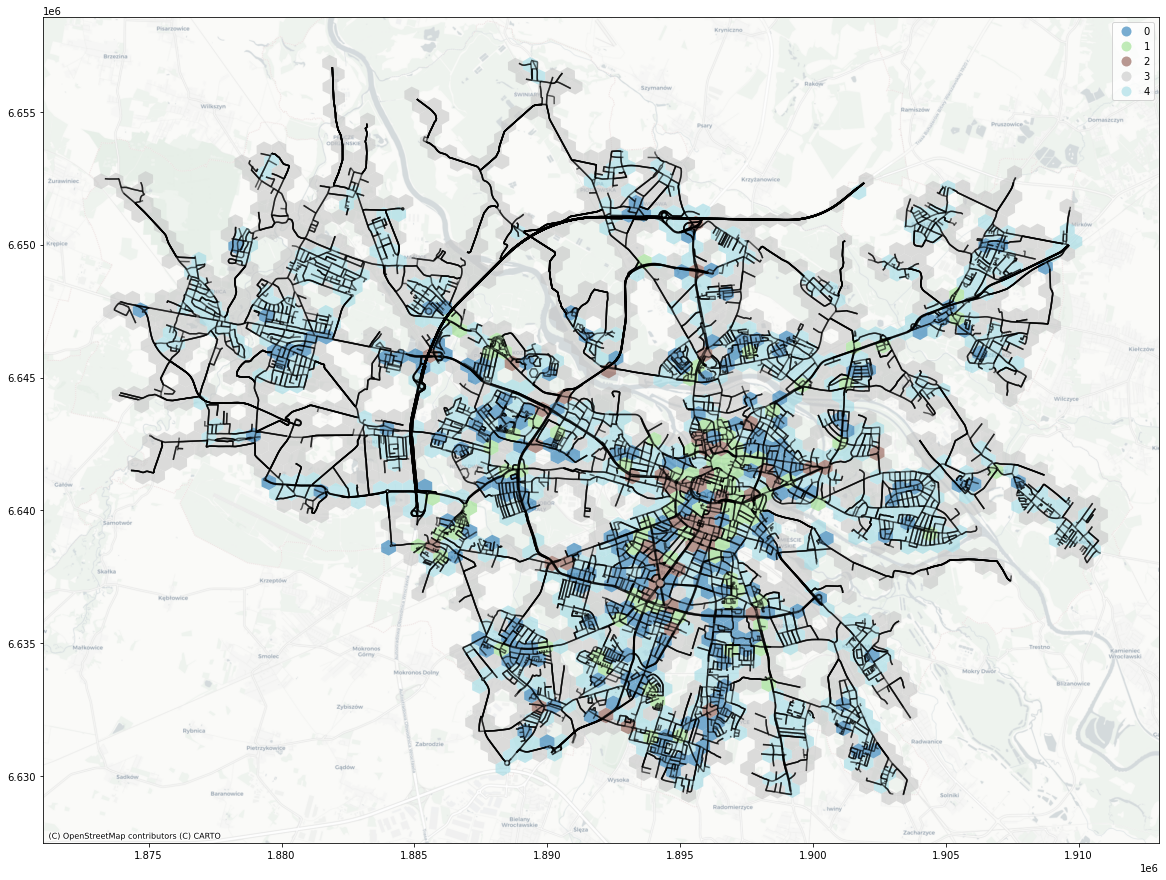

In [38]:
from src.tools.vis_utils import plot_hexagons_map

city = "Wrocław"
plot_hexagons_map(hexagons_clustered[hexagons_clustered["city"] == city], edges[edges["city"] == city], "cluster")

In [21]:
# from scipy.cluster.hierarchy import dendrogram, linkage
# from matplotlib import pyplot as plt

# linked = linkage(y_df.drop(columns="cluster").values, method="ward")

# # labelList = range(1, 11)

# plt.figure(figsize=(10, 7))
# dendrogram(linked)
#             # orientation='top',
#             # # labels=labelList,
#             # distance_sort='descending',
#             # show_leaf_counts=True)
# plt.show()

In [14]:
y_df

,x_0,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,...,x_21,x_22,x_23,x_24,x_25,x_26,x_27,x_28,x_29,cluster
h3_id,,,,,,,,,,,,,,,,,,,,,
891e05901b3ffff,-0.015911,-0.284855,0.135377,0.419759,0.574276,0.666429,-0.274522,-0.076159,0.675333,0.223851,...,-0.446038,-0.226006,0.265533,0.191518,0.548306,0.006264,-0.133650,-0.117059,0.141365,1
891e05901b7ffff,-0.114149,-0.409930,0.275922,0.554632,0.719459,0.845199,-0.561178,0.009423,1.008744,0.387914,...,-0.533717,-0.296988,0.576436,0.269766,0.814186,-0.193459,-0.190237,-0.017637,0.210478,1
891e0590527ffff,-0.310624,-0.660079,0.557010,0.824376,1.009824,1.202737,-1.134491,0.180586,1.675565,0.716041,...,-0.709075,-0.438952,1.198240,0.426262,1.345945,-0.592903,-0.303411,0.181208,0.348705,1
891e059052fffff,-0.015911,-0.284855,0.135377,0.419759,0.574276,0.666429,-0.274522,-0.076159,0.675333,0.223851,...,-0.446038,-0.226006,0.265533,0.191518,0.548306,0.006264,-0.133650,-0.117059,0.141365,1
891e0590537ffff,0.326638,-4.282452,5.536577,2.302559,3.647885,4.577082,-3.958648,1.172679,8.260997,1.742374,...,0.213143,-0.528662,3.838651,1.000385,4.500341,-3.245367,-4.211488,1.225464,2.060641,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
891f725ae47ffff,-0.212387,-0.535004,0.416466,0.689504,0.864641,1.023968,-0.847835,0.095004,1.342154,0.551978,...,-0.621396,-0.367970,0.887338,0.348014,1.080065,-0.393181,-0.246824,0.081785,0.279591,1
891f725ae4fffff,-0.210392,-0.601067,0.333087,0.835112,0.890303,1.386326,0.764742,0.724449,0.950982,-0.765866,...,-1.061554,-1.029691,0.141784,0.643425,2.610920,-1.076472,-0.208775,-1.583607,0.944038,1
891f725ae5bffff,0.157823,0.508305,0.167021,0.438886,0.651417,0.384552,0.930958,0.369015,0.562698,-0.810997,...,-0.814440,-0.487002,-0.797305,0.282986,1.754546,-0.741255,-0.404366,-1.047877,0.121137,1


In [29]:
from src.tools.vis_utils import plot_clusters
embedding = reduce_umap(hex_agg, n_components=2, n_neighbors=30, metric="euclidean")[0]
embedding["cluster"] = y_df["cluster"]
plot_clusters(embedding)

In [30]:
hex_tfidf_by_cluster = hex_agg.join(y_df).groupby(by="cluster")

In [31]:
hex_tfidf_by_cluster_mean = hex_tfidf_by_cluster.mean().reset_index()
hex_tfidf_by_cluster_mean

,cluster,oneway_True,lanes_1,lanes_2,lanes_3,lanes_4,lanes_5,lanes_6,lanes_7,lanes_8,...,x_20,x_21,x_22,x_23,x_24,x_25,x_26,x_27,x_28,x_29
0,0,17.316901,4.176056,10.404930,4.492958,1.774648,0.306338,0.017606,0.003521,0.0,...,9.091197,12.682765,-3.780605,6.628749,20.817438,18.537352,-1.924956,-8.522922,-5.839723,-6.521183
1,1,6.208406,1.479860,3.728546,1.887040,0.734676,0.101576,0.004378,0.000876,0.0,...,2.293696,4.174565,-1.486505,2.046514,7.166979,6.263437,-0.287366,-1.964819,-2.079975,-1.921951
2,2,6.118947,1.066316,5.681053,1.994737,0.714737,0.061053,0.003158,0.000000,0.0,...,4.114586,6.570713,-2.039014,3.179233,11.419750,9.610799,-1.115901,-4.015350,-2.329854,-1.237126
3,3,0.854518,0.141909,1.173047,0.228178,0.098520,0.013272,0.000000,0.000000,0.0,...,3.463557,4.977228,-2.045005,0.551283,6.990804,5.515030,-1.961026,0.082940,-1.243475,-0.047513
4,4,7.003876,1.310078,4.139535,1.271318,0.554264,0.046512,0.000000,0.000000,0.0,...,2.569308,10.540597,1.252380,1.995618,20.146269,16.565231,1.244995,-4.028119,-0.006864,-0.461350
5,5,12.697500,3.842500,6.305000,1.742500,0.590000,0.037500,0.002500,0.000000,0.0,...,7.723194,9.704826,-4.578688,3.434652,16.516430,12.138864,-1.921127,-4.600592,-2.168804,-5.234441
6,6,0.517091,0.097314,0.727764,0.313045,0.123823,0.021451,0.001221,0.000000,0.0,...,0.839100,1.439936,-0.519160,0.193182,2.527494,2.062578,-0.410145,-0.330877,-0.374544,-0.277321
7,7,10.167910,2.350746,5.352612,3.727612,1.432836,0.195896,0.016791,0.000000,0.0,...,3.527568,7.207299,-1.358904,3.699429,10.840304,11.727040,-1.183693,-2.885195,-5.006693,-3.382905
8,8,26.954023,8.333333,14.310345,6.137931,1.620690,0.183908,0.011494,0.000000,0.0,...,14.954171,17.392479,-4.415566,9.770970,30.534149,27.202927,-1.807117,-13.736680,-7.493257,-9.548135
9,9,0.964794,0.194757,1.563670,0.392509,0.141573,0.019101,0.001873,0.000000,0.0,...,1.460289,2.958874,-0.970818,0.459926,5.013062,3.930633,-0.982421,-0.464012,-0.425545,-0.280132


In [32]:
from src.tools.feature_extraction import FEATURESET
for feature_name in FEATURESET.keys():
    fig = px.bar(hex_tfidf_by_cluster_mean, x="cluster", y=list(filter(lambda x: feature_name in x, hex_tfidf_by_cluster_mean.columns)), width=1300, title=feature_name)
    fig.update_layout(
        xaxis = dict(
            tickmode = 'linear',
        )
    )
    fig.show()

ImportError: cannot import name 'FEATURESET' from 'src.tools.feature_extraction' (d:\Projekty\Programowanie\Studia\Semestr10\gis\osm-road-infrastructure\src\tools\feature_extraction.py)

In [27]:
y_df

,x_0,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,...,x_21,x_22,x_23,x_24,x_25,x_26,x_27,x_28,x_29,cluster
h3_id,,,,,,,,,,,,,,,,,,,,,
891e05901b3ffff,-0.147423,0.324401,-0.272509,-0.501775,-0.195316,-0.540840,0.014604,-0.188135,-0.034065,0.420092,...,-0.259665,-0.281277,-0.264207,0.336241,-0.215263,-0.247919,-0.012853,-0.165946,-0.034145,17
891e05901b7ffff,-0.346546,0.612161,-0.566424,-0.790106,-0.402225,-0.746361,-0.166129,-0.332428,-0.183026,0.531855,...,-0.270777,-0.551982,-0.346566,0.747577,-0.337576,-0.273248,0.108979,-0.322631,-0.074206,9
891e0590527ffff,-0.744793,1.187680,-1.154252,-1.366768,-0.816042,-1.157402,-0.527594,-0.621012,-0.480949,0.755382,...,-0.293001,-1.093392,-0.511283,1.570250,-0.582202,-0.323905,0.352641,-0.636002,-0.154327,9
891e059052fffff,-0.147423,0.324401,-0.272509,-0.501775,-0.195316,-0.540840,0.014604,-0.188135,-0.034065,0.420092,...,-0.259665,-0.281277,-0.264207,0.336241,-0.215263,-0.247919,-0.012853,-0.165946,-0.034145,17
891e0590537ffff,-1.356699,2.207561,-4.589529,-4.666032,-6.369331,-8.087285,0.288927,-3.206888,-2.936691,0.620185,...,1.476932,-3.742114,-3.149361,4.304876,-4.130321,-0.823953,4.838062,-3.881491,1.161972,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
891f724dec3ffff,0.265580,0.017193,-0.179161,-0.646706,0.257965,-0.913032,0.422216,0.089278,0.108957,0.804046,...,-0.537007,-0.356452,-0.043233,-0.064980,-0.278634,-0.309247,-0.235608,0.069818,-0.291689,17
891f724dec7ffff,0.265580,0.017193,-0.179161,-0.646706,0.257965,-0.913032,0.422216,0.089278,0.108957,0.804046,...,-0.537007,-0.356452,-0.043233,-0.064980,-0.278634,-0.309247,-0.235608,0.069818,-0.291689,17
891f724decfffff,0.265580,0.017193,-0.179161,-0.646706,0.257965,-0.913032,0.422216,0.089278,0.108957,0.804046,...,-0.537007,-0.356452,-0.043233,-0.064980,-0.278634,-0.309247,-0.235608,0.069818,-0.291689,17


In [39]:
embedding_to_save_df = gpd.GeoDataFrame(y_df.join(hexagons[["parent", "geometry", "city", "resolution"]]).rename(columns={"parent": "h3_parent_id"}))
embedding_to_save_df.to_pickle(PROCESSED_DATA_DIR.joinpath("road_embedding.pkl.gz"))

In [40]:
hexagons.to_pickle(PROCESSED_DATA_DIR.joinpath("hexagons.pkl.gz"))

In [37]:
embedding_to_save_df

,x_0,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,...,x_25,x_26,x_27,x_28,x_29,cluster,h3_parent_id,geometry,city,resolution
h3_id,,,,,,,,,,,,,,,,,,,,,
891e2047227ffff,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,881e204723fffff,"POLYGON ((17.09719 51.11886, 17.09722 51.11718...",Wrocław,9
891e2041867ffff,-5.378747,0.771603,-5.749843,1.119685,0.665263,-11.331374,3.179559,-1.485957,-0.268744,2.034375,...,0.396109,-2.198904,-5.934234,-2.379401,-0.910382,10,881e204187fffff,"POLYGON ((16.96557 51.05686, 16.96561 51.05518...",Wrocław,9
891e20404dbffff,-0.191601,0.169056,-0.106877,-0.186770,-0.165082,-1.016273,0.643773,0.267196,0.045801,-0.072752,...,-0.418359,-0.180219,-0.422031,-0.133116,-0.515161,17,881e20404dfffff,"POLYGON ((16.90358 51.13577, 16.90362 51.13409...",Wrocław,9
891e2040c33ffff,-0.582006,1.272617,-3.804693,-1.456747,-1.619986,-4.069328,2.944317,-0.548824,0.143232,3.027559,...,-1.670312,-1.567980,-3.621682,-0.908762,-0.483289,8,881e2040c3fffff,"POLYGON ((17.01939 51.11909, 17.01942 51.11741...",Wrocław,9
891e20423d7ffff,-0.336837,1.199190,-0.641221,-0.668527,-0.484690,-1.996236,0.930828,-0.143680,-0.103833,-0.120156,...,-0.831711,-0.230537,-0.427219,-0.588992,-0.546942,9,881e20423dfffff,"POLYGON ((16.92820 51.15671, 16.92824 51.15503...",Wrocław,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
891f5104d97ffff,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,881f5104d9fffff,"POLYGON ((23.10581 53.10713, 23.10569 53.10549...",Białystok,9
891f5106913ffff,2.644778,2.481965,-10.605491,-8.179556,-5.400757,-10.453819,8.328604,1.574989,4.924528,1.637846,...,-10.225742,-1.871821,1.051573,0.324489,-6.181804,7,881f510691fffff,"POLYGON ((23.10508 53.13414, 23.10497 53.13251...",Białystok,9
891f51a992fffff,-1.089414,0.460215,-1.909310,-2.270251,0.244078,-2.293188,1.017712,-0.971802,0.928282,0.669215,...,-1.860974,-0.581521,-0.273016,-1.039297,-0.171614,9,881f51a993fffff,"POLYGON ((23.19803 53.15916, 23.19791 53.15752...",Białystok,9


In [53]:
zeros = torch.zeros((1, X.shape[1]))
model(zeros).detach().numpy().squeeze()

array([ 0.0555021 ,  0.04344444,  0.00668686, -0.19877295,  0.00940313,
       -0.349162  ,  0.1700421 , -0.02272386,  0.11920231,  0.3097641 ,
       -0.13769932,  0.25137907,  0.03780234,  0.22747263, -0.31611007,
       -0.15458846,  0.08668634,  0.08182073, -0.05827295,  0.18888496,
       -0.02332959, -0.24750751, -0.00365096, -0.2012625 , -0.05933614,
       -0.10311864, -0.23276374, -0.12063856, -0.01470058,  0.00615425],
      dtype=float32)